# Convert hires images to character-based images

In [1]:
from matplotlib import pyplot as plt
from PIL import Image, ImageOps
import imageio.v3 as iio
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import sklearn
import os
from sklearn.cluster import KMeans
from tqdm import tqdm

SCREEN_WIDTH_CHARS = 40
SCREEN_HEIGHT_CHARS = 25
CHAR_WIDTH = 8
CHAR_HEIGHT = 8
CLUSTER_COUNT = 256 #- 28    Bond:256, Fryba:256-28 to have space for font
FONT_APPENDIX = 'assets/apple_ii.bin'
FONT_APPENDIX_OFFSET = 8 * 0  # in bytes, seek n bytes (8 * characters)


In [2]:
def image_to_patches(img) -> np.ndarray:
    # create a set of 8x8 patches to cover whole 320x200 image
    patches = np.zeros((SCREEN_HEIGHT_CHARS, SCREEN_WIDTH_CHARS, CHAR_HEIGHT, CHAR_WIDTH), dtype=np.uint8)
    for i in range(SCREEN_HEIGHT_CHARS):  # y axis
        for j in range(SCREEN_WIDTH_CHARS):  # x axis
            x = img[i*CHAR_HEIGHT:i*CHAR_HEIGHT+CHAR_HEIGHT, j*CHAR_WIDTH:j*CHAR_WIDTH+CHAR_WIDTH]
            patches[i, j] = x
    return patches

# create embedding for each patch
# use the average color of the patch as first level, average of 4x4 blocks as second level, average of 2x2 blocks as third level, and the color of each pixel as the last level
# level 1 will have 1 value, level 2 will have 9 values, level 3 will have 16 values, and level 4 will have 64 values
def embed_patch(patch: np.ndarray) -> np.ndarray:
    levels = []
    for _ in range(1):
        levels.append(np.mean(patch))
    # Append 4x4 
    kernel = np.ones((4, 4))
    conv_result = convolve2d(patch, kernel, stride=2)
    levels.append(conv_result)
    # Append 2x2
    kernel = np.ones((2, 2))
    conv_result = convolve2d(patch, kernel, stride=2)
    levels.append(conv_result)
    # Append individual pixels
    levels.append(patch)
    flattened_elements = [np.ravel(element) if isinstance(element, np.ndarray) else np.array([element]) for element in levels]
    return np.concatenate(flattened_elements)

def embed_patches(_patches: np.ndarray) -> list:
    # Make embedding of all 1000 patches
    embedded_patches = []
    for i in range(SCREEN_HEIGHT_CHARS):  # y axis
        for j in range(SCREEN_WIDTH_CHARS):  # x axis
            embedded_patches.append(embed_patch(_patches[i, j]))
    np.array(embedded_patches).shape
    return embedded_patches


def extract_patch(embedded_patch: np.ndarray) -> np.ndarray:
    """Input ndarray (85,). Return 8x8 patch float"""
    return embedded_patch[-CHAR_WIDTH*CHAR_HEIGHT:].reshape(8, 8)
    
def extract_first_original_patch(_patches, screen_idx: int, kmeans: sklearn.cluster._kmeans.KMeans) -> np.ndarray:
    # screen_idx is 0-255 index of patch predicted by kmeans for given place in original image
    # kmeans.labels_ is 1000 array of 0-255 of index values
    # Return 8x8 patch from original image
    for i, label in enumerate(kmeans.labels_):
        if label == screen_idx:
            return _patches[i // SCREEN_WIDTH_CHARS, i % SCREEN_WIDTH_CHARS]

def extract_best_original_patch(screen_idx: int, kmeans: sklearn.cluster._kmeans.KMeans, emb_patches: list) -> np.ndarray:
    # Find real original patch that is closest to the predicted cluster center.
    # For now we only use cluster center
    # Return 8x8 patch from original image
    # this_cluster_embedding = []
    # for ord, label in enumerate(kmeans.labels_):
    #     if label == screen_idx:
    #         this_cluster_embedding.append(extract_patch(emb_patches[ord]))
    # return this_cluster_embedding[0]  # return first candidate TODO find the closest to cluster center
    return extract_patch(kmeans.cluster_centers_[screen_idx])

def convolve2d(image, kernel, stride):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape
    
    # Calculate output dimensions
    output_height = (image_height - kernel_height) // stride + 1
    output_width = (image_width - kernel_width) // stride + 1
    
    # Initialize the output array
    output = np.zeros((output_height, output_width))
    
    # Perform the convolution
    for y in range(0, image_height - kernel_height + 1, stride):
        for x in range(0, image_width - kernel_width + 1, stride):
            output[y // stride, x // stride] = np.sum(
                image[y:y + kernel_height, x:x + kernel_width] * kernel
            )
    return output

def frame_to_screen(frame) -> np.ndarray:
    screen_chars = np.zeros((SCREEN_HEIGHT_CHARS, SCREEN_WIDTH_CHARS), dtype=np.uint8)  # hold id of patch
    patchis = image_to_patches(frame)
    for i in range(SCREEN_HEIGHT_CHARS):  # y axis
        for j in range(SCREEN_WIDTH_CHARS):  # x axis
            screen_chars[i, j] = kmeans.predict(embed_patch(patchis[i, j]).reshape(1, -1))[0]
    return screen_chars

def floyd_steinberg_dithering(image):
    image = Image.fromarray(image)
    image = ImageOps.grayscale(image)
    image = image.convert('1')
    return image

# Convert single image to font

## For video scroll down

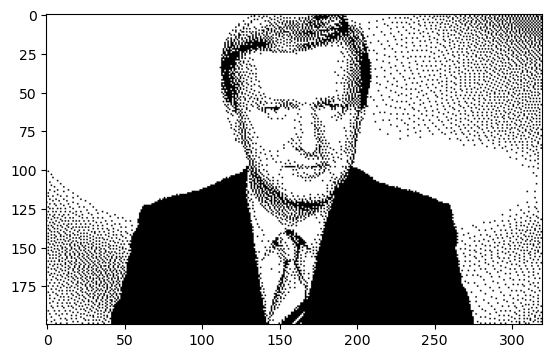

In [753]:
im = iio.imread('assets/fryba.png')
input = im[:, :, 0]

# Plot the image
plt.imshow(input, cmap='gray')

In [5]:
patches = image_to_patches(input)
embedded_patches = embed_patches(patches)

In [758]:
# Create 256 K-means clusters from the patches using the embedding
print(f"Input 1000 embedded patches {np.array(embedded_patches).shape}")
kmeans = KMeans(n_clusters=CLUSTER_COUNT, max_iter=30000, random_state=0).fit(np.array(embedded_patches))
print(f"Output {CLUSTER_COUNT} cluster centers of embeddings {kmeans.cluster_centers_.shape}")

Input 1000 embedded patches (1000, 90)
Output 256 cluster centers of embeddings (256, 90)


(array([ 2263.,  1573.,   911.,   664.,  1381.,   651.,  1347.,  1760.,
         1357.,   147.,    63.,   124.,   719.,   208.,  1823.,   989.,
          162.,   399.,   162.,   148.,   130.,  1426.,   170.,    87.,
          252.,   114.,    37.,    83.,   216.,   125.,  1342.,   141.,
          316.,    59.,   216.,   136.,   398.,   124.,   300.,  7645.,
          718.,    99.,   837.,   126.,  1692.,    68.,    72.,   273.,
          258.,   163.,   750.,   248.,   350.,   192.,   201.,   291.,
          220.,   556.,    57.,   341.,    57.,   121.,   297.,  1885.,
          239.,    86.,  1294.,   492.,   295.,    78.,   145.,   795.,
          222.,   896.,   192.,    54.,   306.,    91.,    79.,  5382.,
          229.,   215.,   217.,  1812.,   582.,   197.,   140.,   135.,
          235.,   184.,    66.,   116.,    96.,  1062.,   299.,   355.,
          362.,   371.,   135.,    53.,   337.,   591.,    92.,   118.,
         3498.,  1032.,   373.,   110.,  2523.,   648.,   197., 

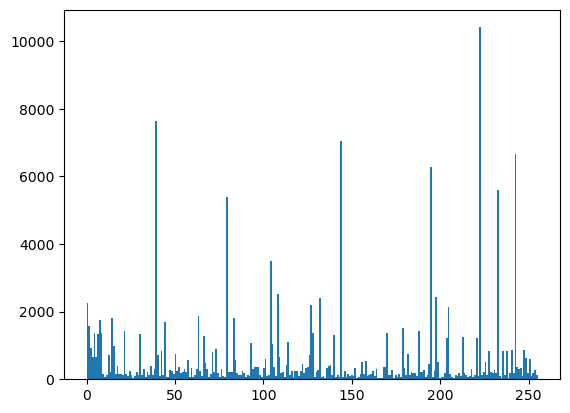

In [14]:
# plot a frequency analysis of kmeans.labels_
# how many times each cluster is used

plt.hist(kmeans.labels_, bins=CLUSTER_COUNT)

In [ ]:
if True:
    # Get first cluster center and plot all patches that belong to it
    which_cluster = 102
    # cluster_center = kmeans.cluster_centers_[which_cluster]
    cluster_patches = []
    for i, label in enumerate(kmeans.labels_):
        if label == which_cluster:
            cluster_patches.append(patches[i // SCREEN_WIDTH_CHARS, i % SCREEN_WIDTH_CHARS])
    print(f"Total number of patches in cluster {which_cluster} is {len(cluster_patches)}")
    # Plot all cluster_patches
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    for i in range(4):
        for j in range(4):
            if i*4+j < len(cluster_patches):
                axs[i, j].imshow(cluster_patches[i*4+j], cmap='gray')
                axs[i, j].axis('off')

In [713]:
if False:
    # Plot first cluster center
    p = extract_patch(kmeans.cluster_centers_[0])
    thresh = threshold_otsu(p)
    p = p > thresh  # try 126
    print(p)
    plt.imshow(extract_patch(p), cmap='gray')
    # plt.imshow(extract_patch(embedded_patches[0]), cmap='gray')

    # plot all patched in the first cluster
    # get list of patches in the first cluster from kmeans.labels_


In [714]:
# Scan the original image with a 8x8 window and replace each patch with the closest cluster center
# def replace_patch(patch: np.ndarray) -> np.ndarray:
#     return kmeans.cluster_centers_[kmeans.predict(embed_patch(patch))]

# cluster_idx = kmeans.predict(embed_patch(patches[0, 0]).reshape(1, -1))[0]
# kmeans.predict(embed_patch(patches[0, 0]))
# replace_patch(patches[0, 0])

def font_to_image(patches) -> np.ndarray:
    screen_chars = np.zeros((SCREEN_HEIGHT_CHARS, SCREEN_WIDTH_CHARS), dtype=np.uint8)  # hold id of patch
    for i in range(SCREEN_HEIGHT_CHARS):  # y axis
        for j in range(SCREEN_WIDTH_CHARS):  # x axis
            screen_chars[i, j] = kmeans.predict(embed_patch(patches[i, j]).reshape(1, -1))[0]
    return screen_chars

screen_chars = font_to_image(patches)

In [715]:
if False:
    # Print screen_chars as 40x25 matrix.
    for i in range(SCREEN_HEIGHT_CHARS):
        for j in range(SCREEN_WIDTH_CHARS):
            print(screen_chars[i, j], end='\t')
        print()

In [739]:
def show_font_image(inp, scr, kmeans, _patches):
    # Reconstruct the image using standardized patches
    AVERAGED_PATCH = False
    new_image = np.zeros((SCREEN_HEIGHT_CHARS*CHAR_HEIGHT, SCREEN_WIDTH_CHARS*CHAR_WIDTH), dtype=np.uint8)
    for i in range(SCREEN_HEIGHT_CHARS):  # y axis
        for j in range(SCREEN_WIDTH_CHARS):  # x axis
            idx_at_position = scr[i][j]
            if AVERAGED_PATCH:
                gray_patch = extract_patch(kmeans.cluster_centers_[idx_at_position])
                thresh = threshold_otsu(gray_patch)
                bw_patch = gray_patch > thresh  # try 126
            else:  # use first original patch in the cluster
                bw_patch = extract_best_original_patch(idx_at_position, kmeans)
            new_image[i*CHAR_HEIGHT:i*CHAR_HEIGHT+CHAR_HEIGHT, j*CHAR_WIDTH:j*CHAR_WIDTH+CHAR_WIDTH] = bw_patch

    # Plot original image next to the new image
    plt.figure()
    plt.imshow(inp, cmap='gray')
    plt.figure()
    plt.imshow(new_image, cmap='gray')



In [ ]:
show_font_image(input, screen_chars, kmeans, patches)

# Convert full video to font

In [ ]:
# Convert video from pickle frame
if True:  # Simple disable
    # input_pickle = 'assets/frames.pkl'
    # output_font = 'assets/video_font.bin'
    # output_screen_buffers = 'assets/video_screens/'  # memory location and .bin will be appended
    input_pickle = 'assets/bond.pkl'
    output_font = 'assets/ministry/vidfont.bin'
    output_screen_buffers = 'assets/ministry_screens/'  # memory location and .bin will be appended
    import pickle
    with open(input_pickle, 'rb') as f:
        frames = pickle.load(f)
    print(f"Number of frames: {len(frames)}")

    screens = []
    embedded_patches = []
    # Calclate font for all frames. Result is amount of clusters
    for frame in tqdm(frames):
        patches = image_to_patches(frame)
        embedded_patches.extend(embed_patches(patches))
    print(f"Number of embedded patches (frames*1000): {len(embedded_patches)}")

    print("Running KMeans training")
    kmeans = KMeans(n_clusters=CLUSTER_COUNT, max_iter=300000, random_state=0).fit(np.array(embedded_patches))
    print(f"Output {CLUSTER_COUNT} cluster centers of embeddings {kmeans.cluster_centers_.shape}")

    # Get representative patch for each character
    print("Generating font")
    font = []
    for ch in tqdm(range(CLUSTER_COUNT)):
        patch = extract_best_original_patch(ch, kmeans, embedded_patches)
        font.append(patch)

    print("Generating screens")
    for frame in tqdm(frames):
        screen_chars = frame_to_screen(frame)
        screens.append(screen_chars)
    print("READY.")


Number of frames: 195


100%|██████████| 195/195 [00:28<00:00,  6.87it/s]


Number of embedded patches (frames*1000): 195000
Running KMeans training
Output 256 cluster centers of embeddings (256, 90)
Generating font


100%|██████████| 256/256 [00:00<00:00, 302462.49it/s]


Generating screens


100%|██████████| 195/195 [00:58<00:00,  3.35it/s]

READY.


In [6]:
# Save font and new_frames as c64 binary

# Convert 8x8 patch to list of 8 bytes
def ch8x8_to_list(data: np.ndarray) -> bytearray:
    assert data.shape == (8, 8)
    result = bytearray()
    for y in range(8):  # Take 8 pixels of the line
        # take 8 pixels of current line, consider value 0 as 0 and value 255 as 1 and make it an 8-bit number
        byte: int = 0
        for x in range(8):
            byte = byte << 1
            byte = byte | (data[y, x] & 1)  #  byte | (~data[y, x] & 1)
        result.append(byte)
    return result

#Save font
font_bin = bytearray()
for ch in range(CLUSTER_COUNT):
    font_bin.extend(ch8x8_to_list(np.array(floyd_steinberg_dithering(font[ch].astype(np.int8)))))
#  Delete bin file if exists
if os.path.exists(output_font):
    os.remove(output_font)

#  Load font appendix
font_appendix = bytearray()
if os.path.exists(FONT_APPENDIX):
    with open(FONT_APPENDIX, 'rb') as f:
        font_appendix.extend(f.read())
# Make first character space
font_appendix[FONT_APPENDIX_OFFSET:FONT_APPENDIX_OFFSET+8] = [0, 0, 0, 0, 0, 0, 0, 0]  # space
font_appendix[FONT_APPENDIX_OFFSET+27*8:FONT_APPENDIX_OFFSET+27*8+8] = [0, 0, 0, 0, 0, 24, 24, 0]  # dot

#  Save output to binary file with .hires extension
with open(output_font, 'wb') as f:
    f.write(bytes(font_bin))
    # if there is space for font, load it and append it to the end of the file
    if CLUSTER_COUNT < 256:
        f.write(font_appendix[FONT_APPENDIX_OFFSET : FONT_APPENDIX_OFFSET+(256-CLUSTER_COUNT)*8])


# Save screens
news_text_pointer = 0  
def save_screen(filename_sufix:str, frame_from:int, count:int, load_address:int=0x04):
    global news_text_pointer, scr_offset
    fn = f'{output_screen_buffers}{filename_sufix}.bin'
    screen_bin = bytearray()
    scr_offset = 0  
    for screen in screens[frame_from:frame_from+count]:
        for i in range(SCREEN_HEIGHT_CHARS):
            for j in range(SCREEN_WIDTH_CHARS):
                screen_bin.append(screen[i, j])
        # Append 24 zeroes to the screen_bin to align in memory and allow screen switching
        screen_bin.extend([0] * 24)
        scr_offset += 1024
    #  Delete bin file if exists
    if os.path.exists(fn):
        os.remove(fn)
    #  Save output to binary file with .hires extension
    with open(fn, 'wb') as f:
        f.write(bytes([0x00, load_address]))
        f.write(bytes(screen_bin[:-24]))  # remove last 24 bytes



In [9]:
# Save all Fryba video blocks

# ACTION: define frames for individial files
# saves_screen('filename', frame_from, count, load_address_high_nybble)
save_screen('F5', 0,  5, 0x64) # this selects frames 0,1,2,3,4. from:0, count:5  Fryba1 at 6400
save_screen('BA', 5,  7, 0x48)
save_screen('BB', 12, 7, 0x64)
save_screen('BC', 19, 7, 0x48)
save_screen('BD', 26, 7, 0x64)
save_screen('BE', 33, 7, 0x48)
save_screen('BF', 40, 7, 0x64)
save_screen('BG', 47, 7, 0x48)
save_screen('BH', 54, 7, 0x64)
save_screen('BI', 61, 7, 0x48)
save_screen('BJ', 68, 7, 0x64)
save_screen('BK', 75, 7, 0x48)
save_screen('BL', 82, 7, 0x64)
save_screen('BM', 89, 7, 0x48)
save_screen('BN', 96, 7, 0x64)


#... depends on video length

In [8]:
# Save all Bond video blocks

# saves_screen('filename', frame_from, count, load_address_high_nybble)
for part in range(0, 5):  # len(frames), 3+6+14+8+8):
    frfrom = part * (3+6+14+8+8)
    partstr = chr(ord('A')+part)
    save_screen(partstr + '0', frfrom + 0,  3, 0x04)
    save_screen(partstr + '1', frfrom + 3,  6, 0x28)
    save_screen(partstr + '2', frfrom + 3+6, 14, 0x48)
    save_screen(partstr + '4', frfrom + 3+6+14, 8, 0xa0)  # load e000 to a000 and copy to e000 first, then load a000
    save_screen(partstr + '3', frfrom + 3+6+14+8, 8, 0xa0)


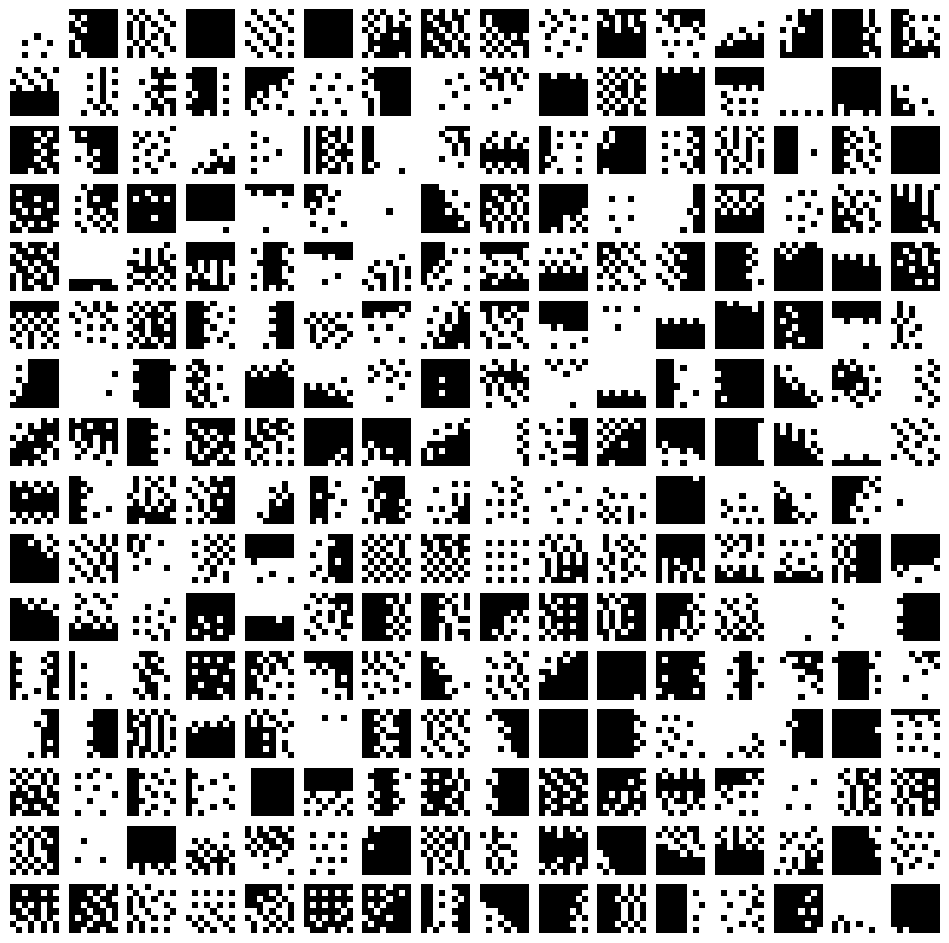

In [9]:
if True:
    # Plot all cluster_patches (font characters 16x16=256)
    fig, axs = plt.subplots(16, 16, figsize=(12, 12))
    for i in range(16):
        for j in range(16):
            if i*16+j < len(font):
                axs[i, j].imshow(np.array(floyd_steinberg_dithering(font[i*16+j])), cmap='gray')
                axs[i, j].axis('off')

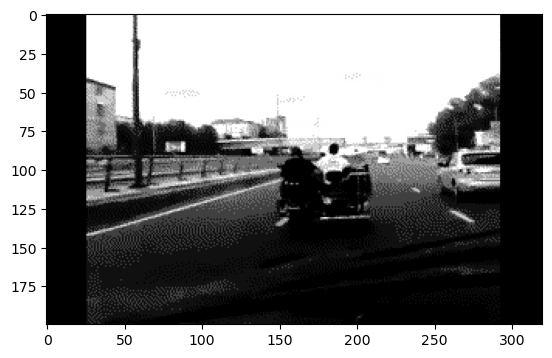

In [7]:
plt.imshow(np.reshape(frames[0], (200, 320, 1)), cmap='gray')


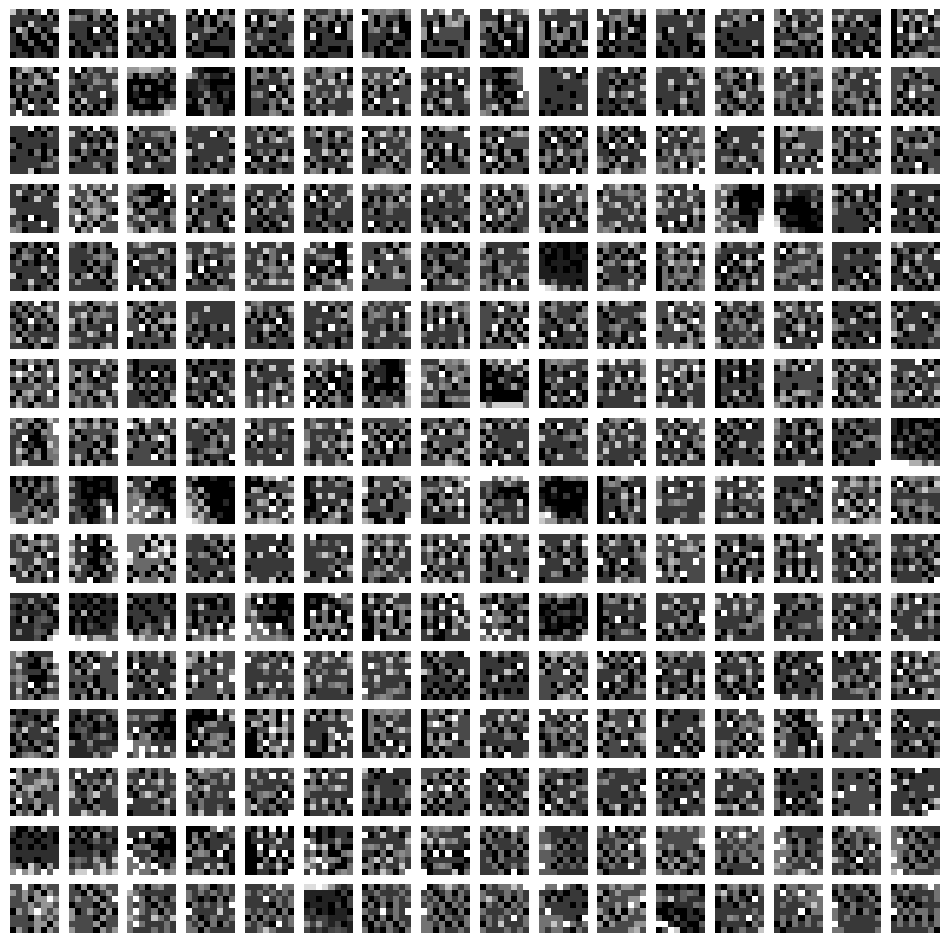

In [7]:
if True:
    idx = 5
    this_cluster_embedding = []
    for ord, label in enumerate(kmeans.labels_):
        if label == idx:
            this_cluster_embedding.append(extract_patch(embedded_patches[ord]))
    # Plot all cluster_patches (font characters 16x16=256)
    fig, axs = plt.subplots(16, 16, figsize=(12, 12))
    for i in range(16):
        for j in range(16):
            if i*16+j < len(this_cluster_embedding) or True:
                axs[i, j].imshow(this_cluster_embedding[i*16+j].astype(float), cmap='gray')
                axs[i, j].axis('off')